<a href="https://colab.research.google.com/github/rmcm24/Oil-Seep-Detection/blob/main/oil_seep_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Throughout this notebook I will give some explanations on my reasoning behind each segment of the code used. The code is self-explanatory, but I decided to add these comments so that my reasoning behind each segment of the code is made clear.

# Google Colab setup

I performed this assignment on google colab in order to leverage their free GPUs. The only setup required was uploading the dataset to my personal drive and accessing it through Colab using the code provided.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/seep_detection/
!ls

/content/drive/MyDrive/seep_detection
train_images_256  train_masks_256


# Manage Imports

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *

# Dataset Exploration/Processing

In this section I investigate and prepare the dataset. Important information to consider:

- What is the structure of the information inside each image/mask? What are the values present in each pixel? How are the classes represented in the masks? In this case, we know that the pixel values range from 0 to 7, with 0 representing no oil seep and the other values representing different types of oil seeps.
- Size of dataset. How many images are there? This will determine how we split the images in train/validation/test folds. As well as determine if we need to augment the dataset.
- What changes need to be done on each image/mask? Are they blurry, do they need rescaling, new dimensions,etc? For masks, if we want only binary classification, we should only have two classes: 0 for no seep and 1 for seep.

After gathering this information, we need to determine what modifications to make to the data and how to feed it into a CNN.

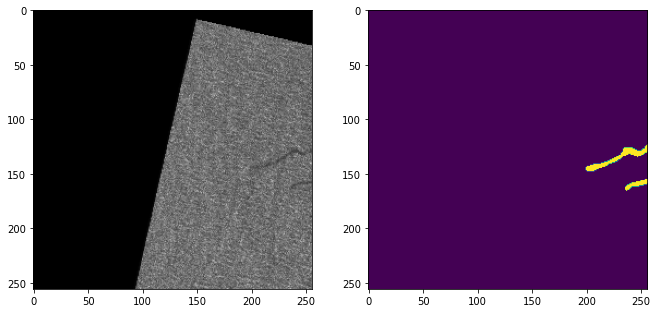

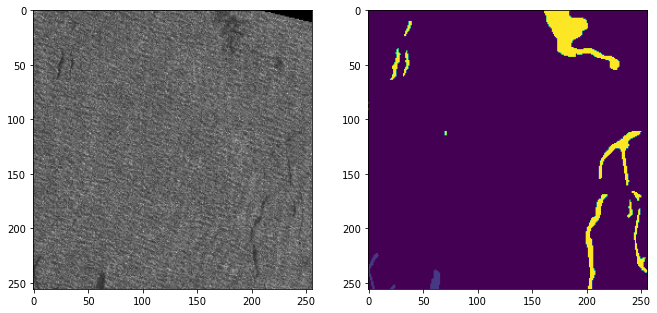

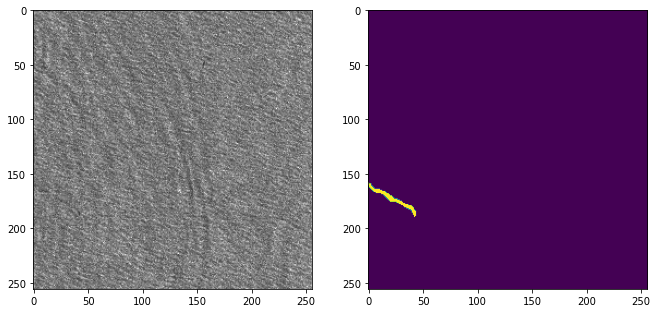

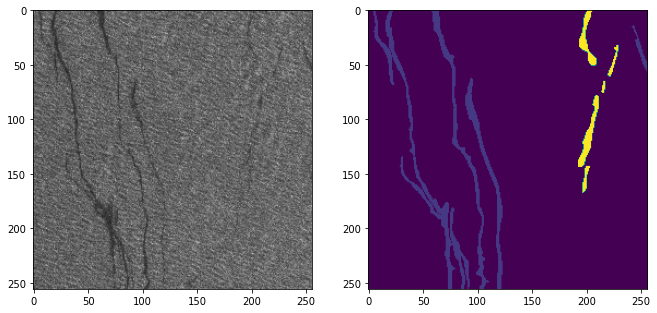

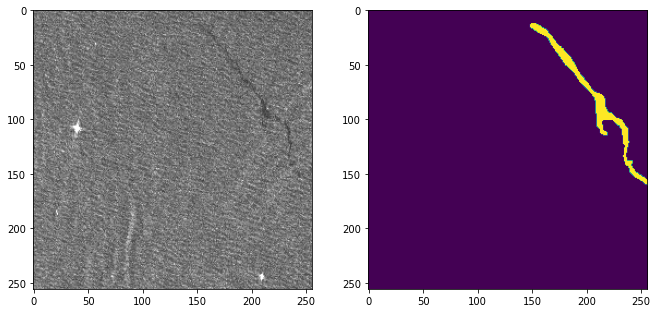

In [4]:
# Read all image/mask files
train_images_files = os.listdir("train_images_256/")
train_masks_files = os.listdir("train_masks_256/")

# In this section I visualize a few image/mask pairs

for i in range(5):
  # cv2_imread transforms the data into the RGB [0:255] range
  image = cv2.imread('train_images_256/'+ train_images_files[i])
  # I use plt.imread for masks so that we can visualize differences between the values that range in [0:7]
  mask = plt.imread('train_masks_256/'+ train_images_files[i])

  # Show images
  fig, ax = plt.subplots(1,2, figsize=(11,7))
  ax[0].imshow(image)
  ax[1].imshow(mask)

The following code will read each image/mask and create a numpy array with all of them. This is performed in order to use the train_test_split() function and as well to use the ImageDataGenerator() function later on.

In addition, we investigate the shape of the images/masks, as well as their pixel values (min, max, mean).


Important: If we want to perform binary classification (seep or no-seep) we need to convert all of the labels from [1:7] into 1. If multi-class classification is desired, this transformation is not necessary.

In [5]:
all_images = []
all_masks = []

for image in train_images_files:
  img = cv2.imread('train_images_256/'+ image)
  mask = plt.imread('train_masks_256/'+ image)
  all_images.append(img)
  #For binary classification: 0-no seep / 1-seep. dtype float64 to match the dtype of images
  mask = (mask >= 1).astype(np.float64)
  #For multi-class classification
  #mask = np.array(mask)
  all_masks.append(mask)

all_images = np.array(all_images)
all_masks = np.array(all_masks)

print('Image Shape:', all_images.shape)
print('Min:', all_images.min(), 'Max:',  all_images.max())
print('Mean:', all_images.mean(), 'Std:', all_images.std())
print('Image Shape:', all_masks.shape)
print('Min:', all_masks.min(), 'Max:',  all_masks.max())
print('Mean:', all_masks.mean(), 'Std:', all_masks.std())

Image Shape: (790, 256, 256, 3)
Min: 0 Max: 255
Mean: 112.49047333922567 Std: 42.923359282282
Image Shape: (790, 256, 256)
Min: 0.0 Max: 1.0
Mean: 0.01805852576147152 Std: 0.13316311579710485


This dataset contains 790 images, which is considered a small dataset. We will use 80% of the data for training, the remaining 20% will be split evenly for validation and testing (10% each). We could split the data in different ways obviously.

As the images are in RGB format with pixel values ranging from 0 to 255, we normalize them by rescaling the pixel values to the range of [0:1].

The masks are in the format of (790,256,256) and in order to feed them into a CNN, we need to reshape them to (790,256,256,1) format by adding an additional dimension.

In [6]:
#Rescale images and reshape masks
all_images = all_images / 255
all_masks = np.expand_dims(all_masks, -1)

# Split images/masks between train/validation/test datasets 80/10/10
X_train, X_test, y_train, y_test = train_test_split(all_images, all_masks, test_size=0.20, random_state=24)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=24)

# Check number of images/masks in each set
for split in [X_train, y_train, X_val, y_val, X_test, y_test]:
  print(len(split))

632
632
79
79
79
79


Given the limited number of images available for training, I chose to apply data augmentation to the images. I used the ImageDataGenerator() function for that purpose. Multiple augmentations can be applied to the images, however, for simplicity, I chose to only use rotation and flip augmentations.

Various augmentation methods can be used as long as the resulting augmented images are still representative of real-world scenarios.

In [7]:
images_datagen = ImageDataGenerator(
                     rotation_range=120,
                     horizontal_flip = True,
                     vertical_flip = True,
                     fill_mode='constant',
                     cval=0)

masks_datagen = ImageDataGenerator(
                     rotation_range=120,
                     horizontal_flip = True,
                     vertical_flip = True,
                     fill_mode='constant',
                     cval=0)


images_datagen.fit(X_train, augment=True, seed=24)
masks_datagen.fit(y_train, augment=True, seed=24)

BATCH_SIZE = 16

image_generator = images_datagen.flow(X_train, batch_size=BATCH_SIZE, shuffle=True, seed=24)
mask_generator = masks_datagen.flow(y_train, batch_size=BATCH_SIZE, shuffle=True, seed=24)

# Combination of both generators to provide a pair image/mask
train_generator = zip(image_generator, mask_generator)

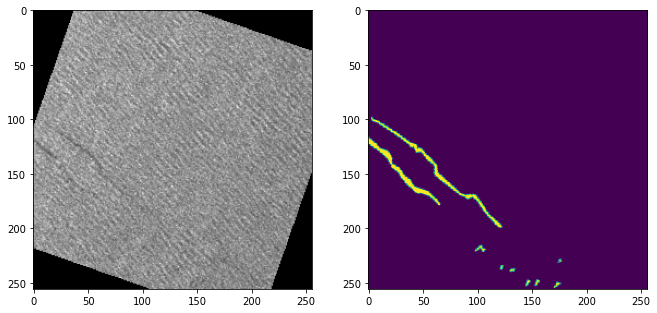

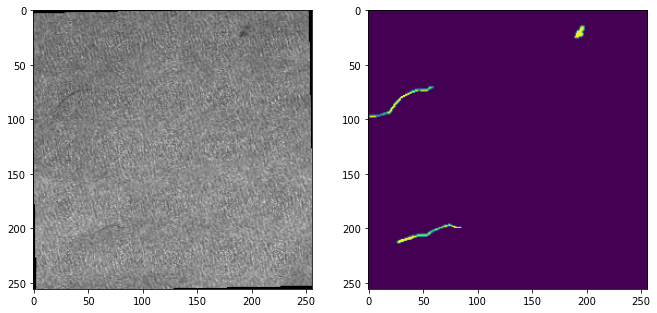

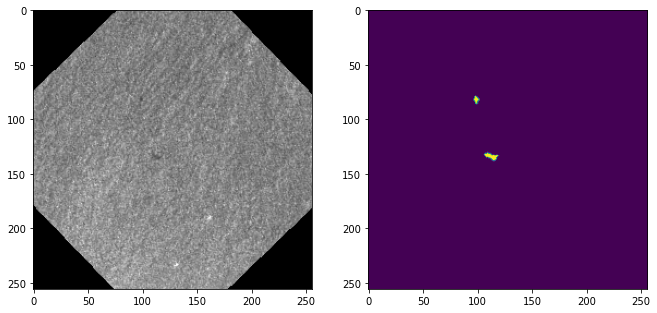

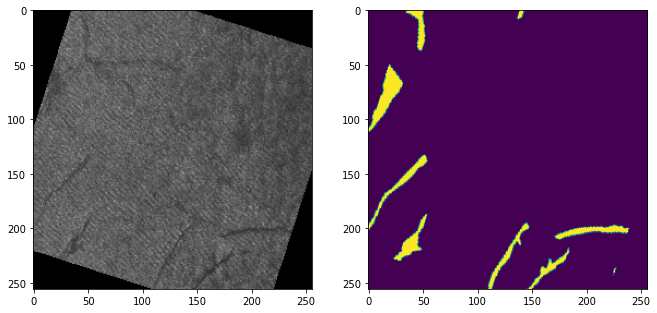

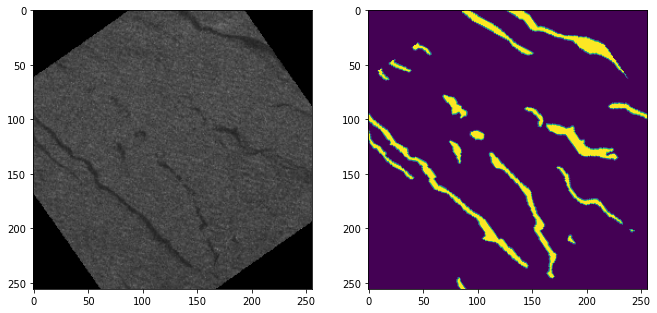

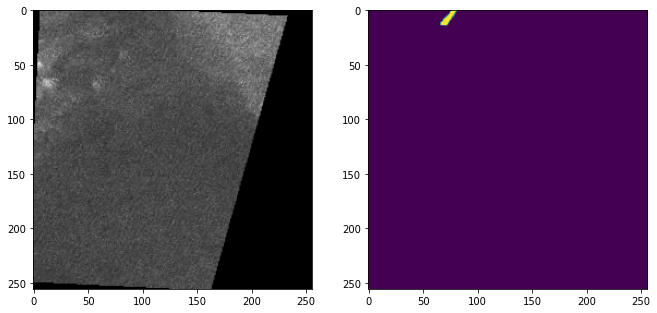

In [8]:
# Visualize several examples of augmented images/masks
for i, (img, mask) in enumerate(train_generator):
    img_test = img[0]
    mask_test = mask[0][:,:,0]
    fig, ax = plt.subplots(1,2, figsize=(11,7))
    ax[0].imshow(img_test)
    ax[1].imshow(mask_test)
    if i == 5:
      break

# Model Building - U-Net

With regards to the model, several options could be taken. Several SoA architectures already exist for the task of image segmentation. We could use transfer learning with a pre-trained model, train an established architecture from scratch on this dataset, or design a custom CNN for this task. This last option is however very time-consuming. 

I have chosen to use the U-Net model architecture, a CNN architecture commonly used for image segmentation tasks, and train it from scratch using the images in this dataset.
The model implementation was based on the U-Net implementation provided in this link: https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

In [9]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x


#This function can be used for binary or multi-class classification by changing the num_classes parameter
def unet(input_shape, num_classes):

   inputs = layers.Input(shape=input_shape)

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   outputs = layers.Conv2D(num_classes, 1, padding="same", activation = "sigmoid")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

# Evaluation Metrics and Loss Function

In the problem at hand, there is a large imbalance between the number of non-seep and seep pixels. Therefore, it is appropriate to use the Dice score as an evaluation metric in this case, as it takes into account the class imbalance by measuring the overlap between the ground truth and predicted mask. Using a simple "accuracy" metric in this situation could lead to erroneous conclusions.

In addition to the Dice score, sensitivity and specificity metrics will also be used to evaluate the performance of the model, as these metrics provide a more detailed understanding of how the model is performing predictions. Sensitivity is the percentage of seep pixels that were correctly classified as such. Specificity is the percentage of non-seep pixels that were correctly classified as such.


Various loss functions can be used for the problem at hand. A few examples of them are: Binary Cross-entropy, Dice Loss and Tversky Loss. The chosen loss function for this assignment is a combination between binary cross-entropy and tversky loss. With this combination, we can not only optimize the predictions for each pixel, but also address the class imbalance by adjusting the Tversky loss to penalize false negatives or false positives, with the goal of maximizing sensitivity or specificity.

It is recommended to experiment with different loss functions and evaluate the performance of the model before finalizing the choice of loss function for the model.

**Summary**

Evaluation Metrics: Dice Score, Sensitivity, Specificity

Loss Function: Focal Tversky Loss

In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true,y_pred)

def sensitivity(y_true, y_pred):    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

ALPHA = 0.8
BETA = 0.2

def tversky(y_true, y_pred, smooth=1, alpha=ALPHA):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def tversky_with_bce_loss(y_true,y_pred):
  return binary_crossentropy(y_true,y_pred) + tversky_loss(y_true,y_pred)

# Training

Here we create the model, specifying the optimizer, learning rate, loss function and evaluation metrics. Exploring different options for each parameter can help optimize model performance. However, this exploration is not covered in the scope of this assignment. 

In [11]:
#Binary Classification
unet_model = unet(input_shape = (256,256,3), num_classes = 1)

unet_model.compile(optimizer=Adam(learning_rate=1e-4), 
                   loss=tversky_with_bce_loss, 
                   metrics=[dice_coef,sensitivity,specificity])
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [12]:
model_name = 'best_model.hdf5'
csv_name = 'best_model.csv'

# Checkpoints to save the best model
model_checkpoint = ModelCheckpoint(model_name, 
                                    monitor='val_loss', 
                                    verbose=1, 
                                    save_best_only=True)

# Define early stop
early_stop = EarlyStopping(
      monitor="val_loss",
      patience=5,
      verbose=1,
)

# Save history in csv
csv_logger = CSVLogger(csv_name)

history = unet_model.fit_generator(train_generator,
                                steps_per_epoch=(len(X_train) // BATCH_SIZE), 
                                epochs=30, 
                                validation_data = (X_val,y_val),
                                validation_steps = (len(X_val) // BATCH_SIZE),
                                callbacks=[early_stop,model_checkpoint,csv_logger]) 

<ipython-input-12-48f34804c05b>:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = unet_model.fit_generator(train_generator,


Epoch 1/30
39/39 [==============================] - ETA: 0s - loss: 1.1545 - dice_coef: 0.0155 - sensitivity: 0.0155 - specificity: 0.9795
Epoch 1: val_loss improved from inf to 1.05265, saving model to best_model.hdf5
39/39 [==============================] - 78s 1s/step - loss: 1.1545 - dice_coef: 0.0155 - sensitivity: 0.0155 - specificity: 0.9795 - val_loss: 1.0526 - val_dice_coef: 0.0516 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/30
39/39 [==============================] - ETA: 0s - loss: 1.0302 - dice_coef: 0.0397 - sensitivity: 0.0000e+00 - specificity: 0.9998
Epoch 2: val_loss improved from 1.05265 to 1.01756, saving model to best_model.hdf5
39/39 [==============================] - 41s 1s/step - loss: 1.0302 - dice_coef: 0.0397 - sensitivity: 0.0000e+00 - specificity: 0.9998 - val_loss: 1.0176 - val_dice_coef: 0.0620 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/30
39/39 [==============================] - ETA: 0s - loss: 1.0203 - dice_coef: 

# Evaluation/Predictions

Here we visualize the information from training. By analyzing the values of the validation and training losses, we can determine whether the model is underfitting or overfitting and decide whether it requires further training. 

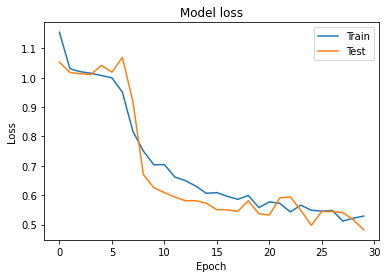

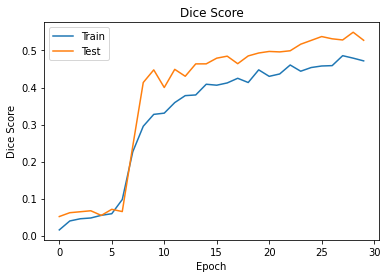

In [15]:
# Plot losses for val and train
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot dice scores for val and train
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice Score')
plt.ylabel('Dice Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

From the loss data, it is apparent that further improvement is possible, as both the training and validation losses are still decreasing. It is recommended to perform additional training by increasing the number of training epochs.

In the next section, we will use the best trained model to make predictions on the test dataset and visualize the results.

3/3 [==============================] - 19s 3s/step


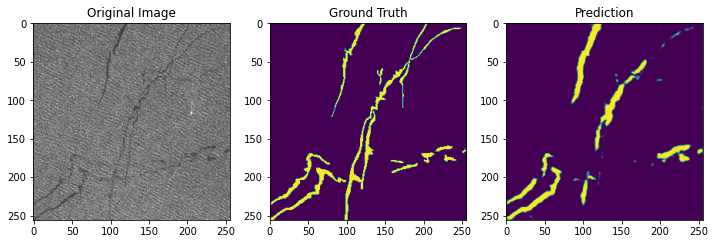

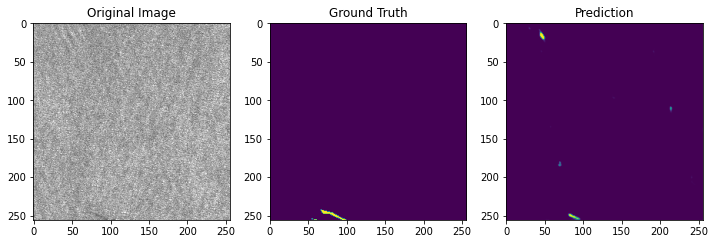

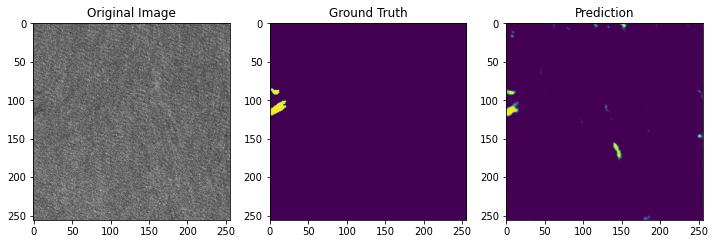

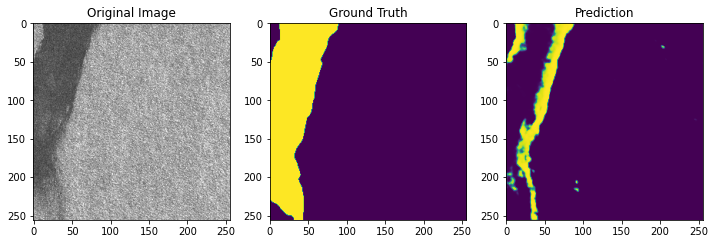

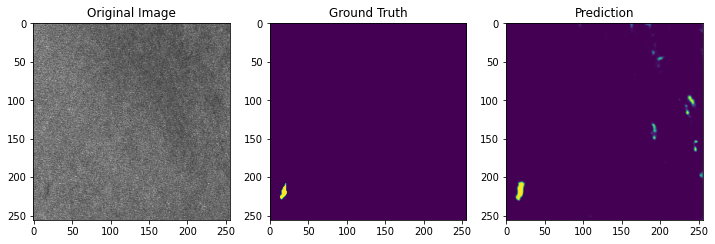

In [16]:
best_model = keras.models.load_model('best_model.hdf5',compile = False)
best_model.compile(optimizer=Adam(learning_rate=1e-4), 
                   loss=tversky_with_bce_loss, 
                   metrics=[dice_coef,sensitivity,specificity])

predictions = best_model.predict(X_test)

for i in range(5):

    fig, ax = plt.subplots(1,3, figsize=(12,8))
    
    ax[0].imshow(X_test[i])
    ax[1].imshow(y_test[i][:,:,0])
    ax[2].imshow(predictions[i][:,:,0])
    #ax[2].imshow((predictions[i] > 0.5).astype(np.float32)[:,:,0])
    


    ax[0].set_title("Original Image")
    ax[1].set_title("Ground Truth")
    ax[2].set_title("Prediction")

    plt.show()


In [17]:
scores = best_model.evaluate(X_test, y_test, steps=(len(X_test) // BATCH_SIZE), verbose=1)
print(f'Dice Score  = {scores[1]} ')
print(f'Sensitivity = {scores[2]} ')
print(f'Specificity = {scores[3]} ')

4/4 [==============================] - 2s 437ms/step - loss: 0.5535 - dice_coef: 0.4986 - sensitivity: 0.6231 - specificity: 0.9804
Dice Score  = 0.4985746145248413 
Sensitivity = 0.6230757236480713 
Specificity = 0.9803706407546997 


The predictions are satisfactory, but further improvement is possible with additional training. It is noteworthy that the model's sensitivity is lower compared to its specificity. If we wish to enhance sensitivity, we can adjust the alpha parameter in the Tversky loss function. 

This decision obviously depends on the scope of the task and what we prefer: we can opt for a model that is more likely to identify all seep pixels, but with a higher risk of false positives, or we can choose a model that is more conservative in its predictions, with a higher risk of false negatives.